# This file contains code of the paper 'Rejecting Novel Motions in High-Density Myoelectric Pattern Recognition using Hybrid Neural Networks'

In [1]:
import scipy.io as sio
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense,Dropout, Input, BatchNormalization
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import keras

Using TensorFlow backend.


In [2]:
# load data
path = './data/data'
data=sio.loadmat(path)

wristPronation = data['wristPronation']
wristSupination = data['wristSupination']
wristExtension = data['wristExtension']
wristFlexion = data['wristFlexion']
handOpen = data['handOpen']
handClose = data['handClose']
shoot = data['shoot']

pinch = data['pinch']
typing = data['typing']
writing = data['writing']
mouseManipulating = data['mouseManipulating']
radialDeviation = data['radialDeviation']
ulnarDeviation = data['ulnarDeviation']

## part1: CNN

In [3]:
def Spatial_Model(input_shape):
    input_layer = Input(input_shape)
    x = Conv2D(filters=32, kernel_size=(3, 3),activation='relu',name = 'conv_layer1')(input_layer)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',name = 'conv_layer2')(x)
    x = Flatten()(x)
    x = Dense(units=1024, activation='relu',name = 'dense_layer1')(x)
    x = Dropout(0.4)(x)
    x = Dense(units=512, activation='relu',name = 'dense_layer2')(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(units=7, activation='softmax',name = 'output_layer')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [4]:
def getIntermediate(layer_name,X,model):
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(X)
    return intermediate_output

def getPointedGesture(X,y,flag):
    index = np.where(y==flag)
    temp = X[index]
    return temp

In [5]:

classNum = 7
X_inliers = np.concatenate((wristPronation,wristSupination,wristExtension,wristFlexion,handOpen,handClose,shoot),axis=0)
print('X_inliers.shape: ',X_inliers.shape)
y_inliers = np.concatenate((np.ones(wristPronation.shape[0])*0,np.ones(wristSupination.shape[0])*1,
                            np.ones(wristExtension.shape[0])*2,np.ones(wristFlexion.shape[0])*3,
                            np.ones(handOpen.shape[0])*4,np.ones(handClose.shape[0])*5,
                            np.ones(shoot.shape[0])*6),axis=0)
print('y_inliers.shape: ',y_inliers.shape)

X_outliers = np.concatenate((typing,writing,mouseManipulating,pinch),axis=0)
print('X_outliers.shape: ',X_outliers.shape)
y_outliers = np.concatenate((np.ones(typing.shape[0])*7,np.ones(writing.shape[0])*8, np.ones(mouseManipulating.shape[0])*9,np.ones(pinch.shape[0])*10),axis=0)
print('y_outliers.shape: ',y_outliers.shape)

X_inliers.shape:  (4070, 12, 8, 3)
y_inliers.shape:  (4070,)
X_outliers.shape:  (2104, 12, 8, 3)
y_outliers.shape:  (2104,)


In [6]:
model = Spatial_Model((12, 8, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 8, 3)          0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 10, 6, 32)         896       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 8, 4, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_layer2 (Dense)         (None, 512)               524800    
__________

In [7]:
trainModel = False

from sklearn.model_selection import train_test_split
X_train, X_test_norm, y_train, y_test_norm = train_test_split(X_inliers, y_inliers, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

y_train_onehot = keras.utils.to_categorical(y_train, classNum)
y_test_onehot = keras.utils.to_categorical(y_test_norm, classNum)
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
if trainModel:
    model.fit(x=X_train, y=y_train_onehot, batch_size=16, epochs=50, shuffle=True, validation_split=0.05)
    model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.01), metrics=['acc'])
    model.fit(x=X_train, y=y_train_onehot, batch_size=16, epochs=50, shuffle=True, validation_split=0.05)
    model.save_weights('./model/modelCNN.h5')
else:
    model.load_weights('./model/modelCNN.h5')


In [8]:
model_evaluate = []
model_evaluate.append(model.evaluate(X_test_norm,y_test_onehot))
print('model_evaluate',model_evaluate)
layer_name = 'dense_layer2'
X_train_intermediate = getIntermediate(layer_name,X_train,model)
X_test_intermediate_norm = getIntermediate(layer_name,X_test_norm,model)

typing_intermediate = getIntermediate(layer_name,typing,model)
writing_intermediate = getIntermediate(layer_name,writing,model)
mouseManipulating_intermediate = getIntermediate(layer_name,mouseManipulating,model)
pinch_intermediate = getIntermediate(layer_name,pinch,model)
radialDeviation_intermediate = getIntermediate(layer_name,radialDeviation,model)
ulnarDeviation_intermediate = getIntermediate(layer_name,ulnarDeviation,model)

814/814 [==============================] - 1s 1ms/step
model_evaluate [[0.07023986597660287, 0.9828009829474316]]


In [9]:
        ## train Data
wristPronation_intermediate_train = getPointedGesture(X_train_intermediate,y_train,0)
wristSupination_intermediate_train = getPointedGesture(X_train_intermediate,y_train,1)
wristExtension_intermediate_train = getPointedGesture(X_train_intermediate,y_train,2)
wristFlexion_intermediate_train = getPointedGesture(X_train_intermediate,y_train,3)
handOpen_intermediate_train = getPointedGesture(X_train_intermediate,y_train,4)
handClose_intermediate_train = getPointedGesture(X_train_intermediate,y_train,5)
shoot_intermediate_train = getPointedGesture(X_train_intermediate,y_train,6)


## test data
wristPronation_intermediate_test = getPointedGesture(X_test_intermediate_norm,y_test_norm,0)
wristSupination_intermediate_test = getPointedGesture(X_test_intermediate_norm,y_test_norm,1)
wristExtension_intermediate_test = getPointedGesture(X_test_intermediate_norm,y_test_norm,2)
wristFlexion_intermediate_test = getPointedGesture(X_test_intermediate_norm,y_test_norm,3)
handOpen_intermediate_test = getPointedGesture(X_test_intermediate_norm,y_test_norm,4)
handClose_intermediate_test = getPointedGesture(X_test_intermediate_norm,y_test_norm,5)
shoot_intermediate_test = getPointedGesture(X_test_intermediate_norm,y_test_norm,6)

typing_intermediate_test = typing_intermediate
writing_intermediate_test = writing_intermediate
mouseManipulating_intermediate_test = mouseManipulating_intermediate
pinch_intermediate_test = pinch_intermediate
radialDeviation_intermediate_test = radialDeviation_intermediate
ulnarDeviation_intermediate_test = ulnarDeviation_intermediate

outlierData = {'typing_intermediate_test':typing_intermediate_test,
               'writing_intermediate_test':writing_intermediate_test,
               'mouseManipulating_intermediate_test':mouseManipulating_intermediate_test,
              'pinch_intermediate_test':pinch_intermediate_test}
motionNameList = ['wristPronation','wristSupination','wristExtension','wristFlexion','handOpen','handClose','shoot']
trainDataDict = {motionNameList[0]:wristPronation_intermediate_train,motionNameList[1]:wristSupination_intermediate_train,
                 motionNameList[2]:wristExtension_intermediate_train,motionNameList[3]:wristFlexion_intermediate_train,
                 motionNameList[4]:handOpen_intermediate_train,motionNameList[5]:handClose_intermediate_train,
            motionNameList[6]:shoot_intermediate_train}
testDataNameList = ['wristPronation','wristSupination','wristExtension','wristFlexion','handOpen','handClose','shoot',
                    'typing','writing','mouseManipulating','pinch','radialDeviation','ulnarDeviation']
testDataDict = {testDataNameList[0]:wristPronation_intermediate_test,testDataNameList[1]:wristSupination_intermediate_test,
                testDataNameList[2]:wristExtension_intermediate_test,testDataNameList[3]:wristFlexion_intermediate_test,
                testDataNameList[4]:handOpen_intermediate_test,testDataNameList[5]:handClose_intermediate_test,
                testDataNameList[6]:shoot_intermediate_test,testDataNameList[7]:typing_intermediate_test[0:150],
                testDataNameList[8]:writing_intermediate_test[0:150],testDataNameList[9]:mouseManipulating_intermediate_test[0:150],
                testDataNameList[10]:pinch_intermediate_test[0:150],testDataNameList[11]:radialDeviation_intermediate_test[0:150],
               testDataNameList[12]:ulnarDeviation_intermediate_test[0:150]}

In [10]:
X_val_intermediate = getIntermediate(layer_name,X_val,model)
wristPronation_intermediate_val = getPointedGesture(X_val_intermediate,y_val,0)
wristSupination_intermediate_val = getPointedGesture(X_val_intermediate,y_val,1)
wristExtension_intermediate_val = getPointedGesture(X_val_intermediate,y_val,2)
wristFlexion_intermediate_val = getPointedGesture(X_val_intermediate,y_val,3)
handOpen_intermediate_val = getPointedGesture(X_val_intermediate,y_val,4)
handClose_intermediate_val = getPointedGesture(X_val_intermediate,y_val,5)
shoot_intermediate_val = getPointedGesture(X_val_intermediate,y_val,6)

valDataDict = {motionNameList[0]:wristPronation_intermediate_val,motionNameList[1]:wristSupination_intermediate_val,
               motionNameList[2]:wristExtension_intermediate_val,motionNameList[3]:wristFlexion_intermediate_val,
               motionNameList[4]:handOpen_intermediate_val,motionNameList[5]:handClose_intermediate_val,
            motionNameList[6]:shoot_intermediate_val}

## part2: autoEncoder

In [11]:
from keras import regularizers
from keras.losses import mean_squared_error
from keras.optimizers import SGD

def autoModel(input_shape):
    input_img = Input(input_shape)
    encoded = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.002))(input_img)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.002))(encoded)
    encoded = BatchNormalization()(encoded)
    decoded = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.002))(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.002))(decoded)
    model = Model(input_img, decoded)
    return model

In [24]:
trainAutoFlag = False

if trainAutoFlag:
    for motionId in range(len(motionNameList)):
        motionName = motionNameList[motionId]
        x_train = trainDataDict[motionName]
        x_val = valDataDict[motionName]

        autoencoder = autoModel((512,))
        autoencoder.compile(loss=mean_squared_error, optimizer=SGD(lr=0.1))

        autoencoder.fit(x_train, x_train,
                        epochs=600,
                        batch_size=16,
                        shuffle=True,
                        validation_data=(x_val, x_val))

        autoencoder.compile(loss=mean_squared_error, optimizer=SGD(lr=0.01))
        autoencoder.fit(x_train, x_train,
                        epochs=300,
                        batch_size=16,
                        shuffle=True,
                        validation_data=(x_val, x_val))
        autoencoder.save_weights('./model/autoencoder/Autoencoder_'+motionName+'.h5')

### Calculate ROC curve

In [25]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.metrics import roc_curve, auc


targetDict = {}
for motionId in range(len(motionNameList)):
    targetList = []
    motionName = motionNameList[motionId]
    print('motionName: ', motionName)
    # load models
    autoencoder = autoModel((512,))
    autoencoder.compile(loss=mean_squared_error, optimizer=Adadelta(lr=0.5))
    autoencoder.load_weights('./model/autoencoder/Autoencoder_'+motionName+'.h5') 
    original = valDataDict[motionName]
    decoded_imgs = autoencoder.predict(original)
    num = decoded_imgs.shape[0]
    for i in range(num):
        X = np.vstack([original[i,:],decoded_imgs[i,:]])
        lose = pdist(X,'braycurtis')
        targetList.append(lose[0])
    targetDict[motionName] = targetList

motionName:  wristPronation
motionName:  wristSupination
motionName:  wristExtension
motionName:  wristFlexion
motionName:  handOpen
motionName:  handClose
motionName:  shoot


In [26]:
mdDict = {}
for motionId in range(len(motionNameList)):
    motionName = motionNameList[motionId]
    print('motionName: ', motionName)
    # load models
    autoencoder = autoModel((512,))
    autoencoder.compile(loss=mean_squared_error, optimizer=Adadelta(lr=0.5))
    autoencoder.load_weights('./model/autoencoder/AutoEncoder_'+motionName+'.h5')
    originalDict = {}
    decodedDict = {}
    for gestureId in range(len(testDataNameList)):
        originalDict[testDataNameList[gestureId]] = testDataDict[testDataNameList[gestureId]]
        decodedDict[testDataNameList[gestureId]] = autoencoder.predict(originalDict[testDataNameList[gestureId]])

    
    reconstruction_error = []
    for gestureID in range(len(testDataNameList)):
        original = originalDict[testDataNameList[gestureID]]
        decoded_imgs = decodedDict[testDataNameList[gestureID]]
        num = decoded_imgs.shape[0]
        for i in range(num):
            X = np.vstack([original[i,:],decoded_imgs[i,:]])
            lose = pdist(X,'braycurtis')
            reconstruction_error.append(lose[0])
    mdDict[motionName] = reconstruction_error

motionName:  wristPronation
motionName:  wristSupination
motionName:  wristExtension
motionName:  wristFlexion
motionName:  handOpen
motionName:  handClose
motionName:  shoot


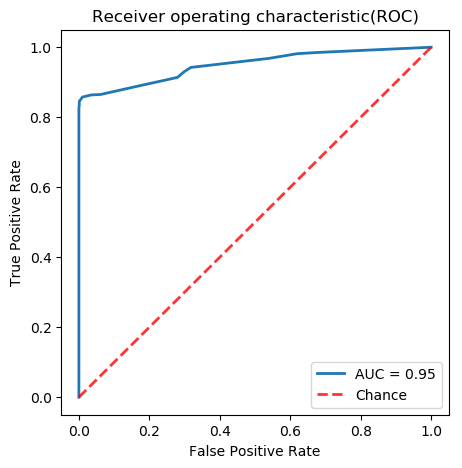

In [27]:
outlierAllNum = 150 * 6  #six novel motions, 150 samples for each motion
y_label = []
for motionId in range(len(motionNameList)):
    motionName = motionNameList[motionId]
    y_label.extend(np.ones(len(testDataDict[motionName])))
y_label.extend(np.zeros(len(testDataDict['typing'])))
y_label.extend(np.zeros(len(testDataDict['writing'])))
y_label.extend(np.zeros(len(testDataDict['mouseManipulating'])))
y_label.extend(np.zeros(len(testDataDict['pinch'])))
y_label.extend(np.zeros(len(testDataDict['radialDeviation'])))
y_label.extend(np.zeros(len(testDataDict['radialDeviation'])))

outliers_fraction_List = []
P_List = []
R_List = []
F1_List = []
TPR_List = []
FPR_List = []

#outliers_fraction = 0.02
for outliers_i in range(-1,101):
    
    outliers_fraction = outliers_i/100
    outliers_fraction_List.append(outliers_fraction)

    
    y_pred = np.zeros(len(y_label))
    thresholdDict = {}
    for motionId in range(len(motionNameList)):
    #    motionId = 0
        motionName = motionNameList[motionId]
        distances = targetDict[motionName]
        distances = np.sort(distances)
        num = len(distances)
#        print('outliers_fraction:',outliers_fraction)
        if outliers_fraction >= 0:
            threshold = distances[num-1-int(outliers_fraction*num)]# get threshold
        if outliers_fraction < 0:
            threshold = 10000.0
        if outliers_fraction == 1.0:
            threshold = 0
        thresholdDict[motionName] = threshold 
        mdDistances = mdDict[motionName]
        y_pred_temp = (np.array(mdDistances)<=threshold)*1
        y_pred = y_pred + y_pred_temp
        
    y_pred = (y_pred>0)*1
    TP = np.sum(y_pred[0:-outlierAllNum])
    FN = len(y_pred[0:-outlierAllNum])-TP
    FP = np.sum(y_pred[-outlierAllNum:])
    TN = outlierAllNum - FP
    t = 0.00001
    P = TP/(TP+FP+t)
    R = TP/(TP+FN+t)
    F1 = 2*P*R/(P+R+t)
    TPR = TP/(TP+FN+t)
    FPR = FP/(TN+FP+t)
    
    P_List.append(P)
    R_List.append(R)
    F1_List.append(F1)
    TPR_List.append(TPR)
    FPR_List.append(FPR)

roc_auc = auc(FPR_List, TPR_List)  
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(FPR_List, TPR_List, lw=2,label='AUC = %0.2f' % ( roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC)')
plt.legend(loc="lower right")
plt.show()

### calculate classification accuracies

In [21]:
resultDict = {}
for motionId in range(len(motionNameList)):
    motionName = motionNameList[motionId]
    # load models
    autoencoder = autoModel((512,))
    autoencoder.compile(loss=mean_squared_error, optimizer=Adadelta(lr=0.5))
    autoencoder.load_weights('./model/autoencoder/AutoEncoder_'+motionName+'.h5')
    # refactore data
    originalDict = {}
    decodedDict = {}
    
    for gestureId in range(len(testDataNameList)):
        originalDict[testDataNameList[gestureId]] = testDataDict[testDataNameList[gestureId]]
        decodedDict[testDataNameList[gestureId]] = autoencoder.predict(originalDict[testDataNameList[gestureId]])
        
    loseDict = {}
    for gestureID in range(len(testDataNameList)):
        
        loseList= []
        original = originalDict[testDataNameList[gestureID]]
        decoded_imgs = decodedDict[testDataNameList[gestureID]]
        num = decoded_imgs.shape[0]
        for i in range(num):
            X = np.vstack([original[i,:],decoded_imgs[i,:]])
            lose = pdist(X,'braycurtis')
            loseList.append(lose[0])
        loseDict[testDataNameList[gestureID]] = loseList

    resultDict[motionName] = loseDict

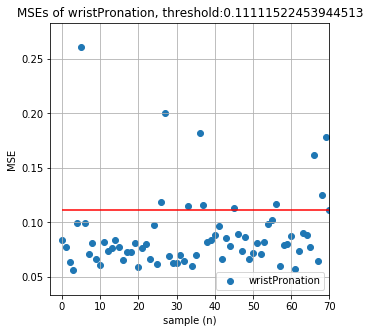

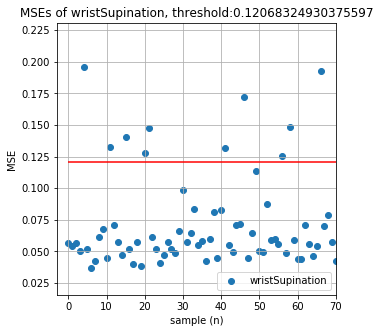

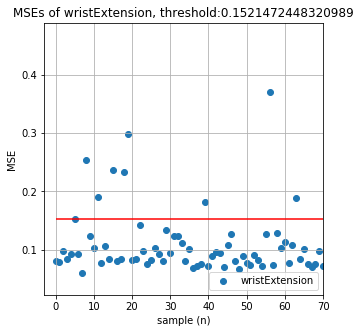

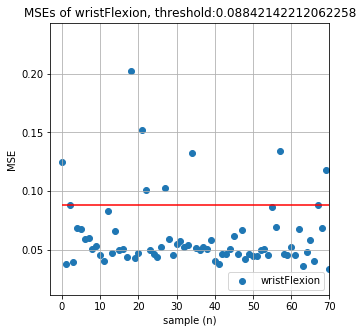

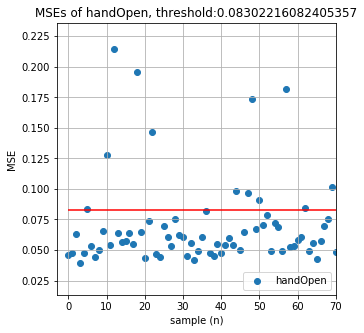

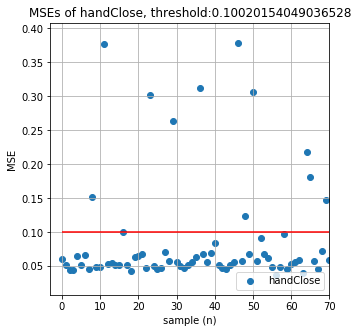

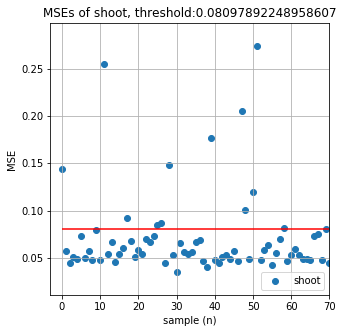

In [22]:
outliers_fraction = 0.15
thresholdDict = {}
for motionId in range(len(motionNameList)):

    motionName = motionNameList[motionId]

    # load model
    autoencoder = autoModel((512,))
    autoencoder.compile(loss=mean_squared_error, optimizer=Adadelta(lr=0.5))
    autoencoder.load_weights('./model/autoencoder/AutoEncoder_'+motionName+'.h5')

    # val data
    original_val = valDataDict[motionName]
    decoded_val = autoencoder.predict(original_val)
    
    loseList= []
    original = original_val
    decoded_imgs = decoded_val
    num = decoded_imgs.shape[0]
    for i in range(num):
        X = np.vstack([original[i,:],decoded_imgs[i,:]])
        lose = pdist(X,'braycurtis')
        loseList.append(lose[0])
    ## calculate threshold for each task
    loseArray = np.array(loseList)
    loseArraySort = np.sort(loseArray)
    anomaly_threshold = loseArraySort[-(int((outliers_fraction*len(loseArray)))+1)]
    thresholdDict[motionName] = anomaly_threshold
    
    # plot lose and threshold
    fig, ax = plt.subplots(figsize=(5, 5))
    t = np.arange(num)
    s = loseArray
    ax.scatter(t,s,label=motionName)
    ax.hlines(anomaly_threshold,0,150,colors = "r")
    ax.set(xlabel='sample (n)', ylabel='MSE',
           title='MSEs of '+ motionName + ', threshold:' + str(anomaly_threshold))
    ax.grid()
    plt.legend(loc="lower right")
    plt.xlim(xmin = -3)
    plt.xlim(xmax = 70)
    plt.show()

{'wristPronation': 0.14482758620689656, 'wristSupination': 0.19327731092436976, 'wristExtension': 0.1623931623931624, 'wristFlexion': 0.25217391304347825, 'handOpen': 0.18269230769230768, 'handClose': 0.20430107526881722, 'shoot': 0.21487603305785125, 'typing': 0.0, 'writing': 0.0, 'mouseManipulating': 0.0, 'pinch': 0.0, 'radialDeviation': 0.0, 'ulnarDeviation': 0.0, 'target overall': 0.19164619164619165}


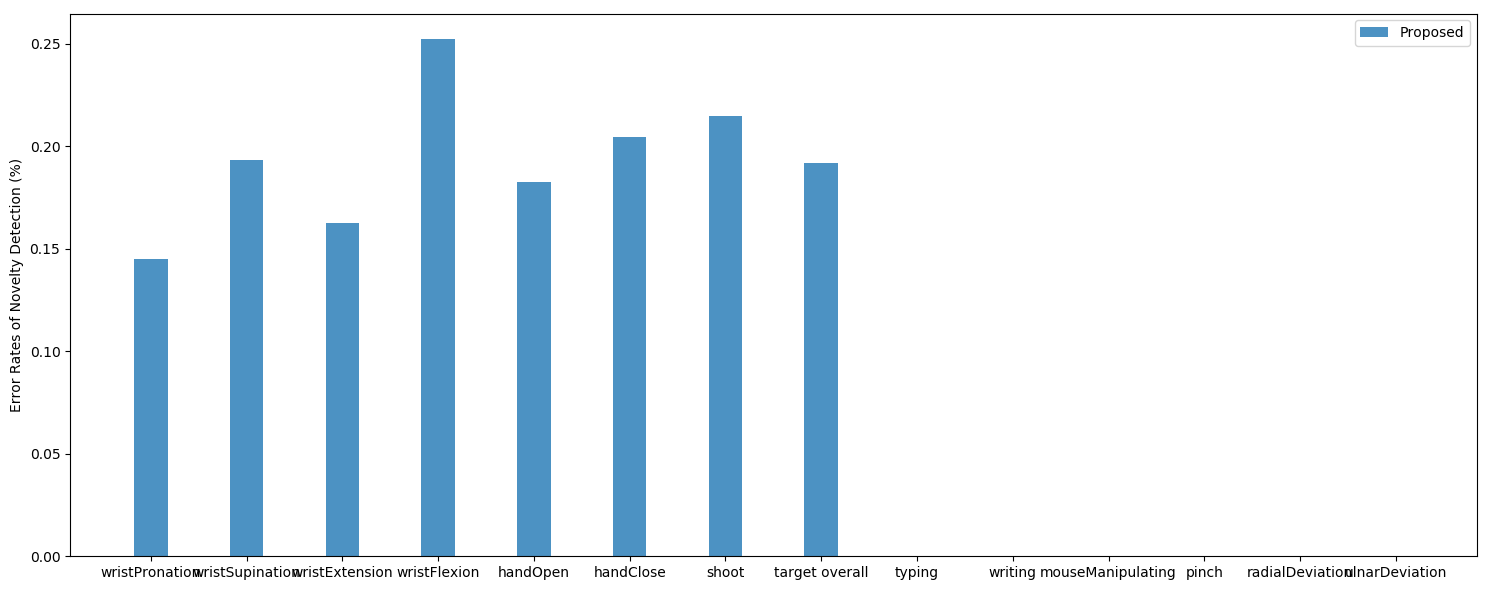

In [23]:
errorSum = 0
testSum = 0
barDict = {}
outlierClass = 6
rejectMotion = {}
for motionId in range(len(testDataNameList)):

    recogList = []
    motionName = testDataNameList[motionId]
    for recogId in range(len(testDataNameList)-outlierClass):
        identyResult = resultDict[testDataNameList[recogId]]
        targetResult = np.array(identyResult[motionName])
        recogList.append((targetResult<=thresholdDict[testDataNameList[recogId]])*1) # 每一个类别有自己的threshold用于拒判
        recogArray = np.array(recogList)
    recogArray = np.sum(recogArray,axis=0)
    recogArray = (recogArray>0)*1
    rejectMotion[testDataNameList[motionId]] = recogArray
    if motionId<(len(testDataNameList)-outlierClass):
        numError = np.sum(1-recogArray)
    else:
        numError = np.sum(recogArray)
    numTarget = len(recogArray)
    if motionId<(len(testDataNameList)-outlierClass):
        errorSum = errorSum + numError
        testSum = testSum + numTarget
    barDict[testDataNameList[motionId]] = (numError/numTarget)
barDict['target overall'] = errorSum/testSum
print(barDict)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(15, 6))

objects = ('wristPronation','wristSupination','wristExtension','wristFlexion','handOpen','handClose','shoot','target overall',
           'typing','writing','mouseManipulating','pinch','radialDeviation','ulnarDeviation')
y_pos = np.arange(len(objects))
proposed = []
for i in range(len(objects)):
    proposed.append(barDict[objects[i]])
bar_width = 0.35
opacity = 0.8
rects2 = plt.bar(y_pos + bar_width, proposed, bar_width,
alpha=opacity,
label='Proposed')


plt.xticks(y_pos + bar_width, objects)
plt.ylabel('Error Rates of Novelty Detection (%)')
plt.legend()
plt.tight_layout()
plt.show()